# Reference

- https://www.kaggle.com/code/yasufuminakama/cassava-resnext50-32x4d-starter-training

# Data Loading

In [3]:
import os

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

import glob

In [4]:
train = pd.read_csv('../data/train.csv')
print(train.shape)
train = train[train["StudyID"] != "002360"].reset_index(drop=True)
train = train[train["StudyID"] != "Not found"].reset_index(drop=True)
print(train.shape)

train2 = pd.read_csv('../data/test.csv')
train2["StudyID"] = train2["StudyID"].map(lambda x: str(x).zfill(6))

train = pd.concat([train, train2]).reset_index(drop=True)

train

(2377, 2)

(2375, 2)


,StudyID,Age
0,001320,39
1,001321,52
2,001322,59
3,001323,54
4,001324,52
...,...,...
2634,000366,26
2635,000368,53
2636,000369,28
2637,000371,33


In [7]:
train = pd.read_csv("../data/train_bone_max.csv")
test = pd.read_csv("../data/test_bone_max.csv")
train["file_path"] = train["file_path"].apply(lambda x: x.replace("stacked_384", "stacked_512"))
test["file_path"] = test["file_path"].apply(lambda x: x.replace("stacked_384", "stacked_512"))
test = test[test["bone_max"] > 100].reset_index(drop=True)
test

,file_path,StudyID,bone_max
0,../data/test_stacked_512/002849/slice_252.png,2849,208
1,../data/test_stacked_512/002849/slice_62.png,2849,255
2,../data/test_stacked_512/002849/slice_181.png,2849,208
3,../data/test_stacked_512/002849/slice_132.png,2849,205
4,../data/test_stacked_512/002849/slice_11.png,2849,179
...,...,...,...
28873,../data/test_stacked_512/002976/slice_160.png,2976,195
28874,../data/test_stacked_512/002976/slice_26.png,2976,206
28875,../data/test_stacked_512/002976/slice_16.png,2976,208
28876,../data/test_stacked_512/002976/slice_44.png,2976,237


# Directory settings

In [8]:
# ====================================================
# Directory settings
# ====================================================
import os
os.environ["OMP_NUM_THREADS"] = "8"

EXP = "exp000"
OUTPUT_DIR = f'../exp/{EXP}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# CFG

In [27]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    apex=True
    print_freq=100
    num_workers=8
    model_name= 'tf_efficientnetv2_s.in21k_ft_in1k' #'swinv2_small_window16_256.ms_in1k' #'tf_efficientnetv2_m.in21k_ft_in1k' #"tf_efficientnet_b3_ns" #'tf_efficientnetv2_m.in21k_ft_in1k' #"convnextv2_tiny.fcmae_ft_in22k_in1k" #"tf_efficientnet_b7_ns" #'tf_efficientnetv2_m.in21k_ft_in1k' #"tf_efficientnet_b3_ns" #"tf_efficientnet_b3_ns" #"tf_efficientnet_b3_ns" #"convnext_small" #"swin_small_patch4_window7_224.ms_in22k_ft_in1k"
    size= 512 #256 #160 #320 #360 #384, 224
    scheduler= "get_cosine_schedule_with_warmup"  #'CosineLRScheduler' # ["get_cosine_schedule_with_warmup", 'ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    if scheduler == "get_cosine_schedule_with_warmup":
      batch_scheduler = True
    else:
      batch_scheduler = False
    epochs=5 #10#10
    warmup_epochs = 1 #1 # epochs // 30
    T_0=epochs # CosineAnnealingWarmRestarts
    lr= 1e-3 #1e-3 #1e-3
    min_lr=1e-6
    batch_size= 48 #32 #32 #64 #128 #128 #80 #64
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    target_size=1
    target_cols=["Age"]
    n_fold=10
    trn_fold= [0] #list(range(n_fold)) #[0,1,2,3,4,5,6,7,8,9]
    mixup=False
    train=True
    inference=False
    
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=5000, random_state=CFG.seed).reset_index(drop=True)
    
print(len(CFG.target_cols))

1


# Library

In [10]:
# ====================================================
# Library
# ====================================================
import sys

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import gc

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, roc_auc_score, label_ranking_average_precision_score, average_precision_score, mean_absolute_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup

import albumentations as A
from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

import warnings 
warnings.filterwarnings('ignore')

from torch.cuda.amp import autocast, GradScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

  from .autonotebook import tqdm as notebook_tqdm


cuda


# Utils

In [11]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = mean_absolute_error(y_true, y_pred)
    return score

@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

# CV split

In [12]:
folds = train.copy()
Fold = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=0)
group = folds["StudyID"]
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds["Age"], group)):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
folds

,file_path,StudyID,Age,bone_max,fold
0,../data/train_stacked_512/002186/slice_62.png,2186,30,230,9
1,../data/train_stacked_512/002186/slice_132.png,2186,30,239,9
2,../data/train_stacked_512/002186/slice_11.png,2186,30,255,9
3,../data/train_stacked_512/002186/slice_84.png,2186,30,235,9
4,../data/train_stacked_512/002186/slice_133.png,2186,30,238,9
...,...,...,...,...,...
490719,../data/train_stacked_512/001704/slice_15.png,1704,28,244,7
490720,../data/train_stacked_512/001704/slice_26.png,1704,28,229,7
490721,../data/train_stacked_512/001704/slice_16.png,1704,28,235,7
490722,../data/train_stacked_512/001704/slice_44.png,1704,28,255,7


In [13]:
folds = folds[folds["bone_max"] > 100].reset_index(drop=True)
folds

,file_path,StudyID,Age,bone_max,fold
0,../data/train_stacked_512/002186/slice_62.png,2186,30,230,9
1,../data/train_stacked_512/002186/slice_132.png,2186,30,239,9
2,../data/train_stacked_512/002186/slice_11.png,2186,30,255,9
3,../data/train_stacked_512/002186/slice_84.png,2186,30,235,9
4,../data/train_stacked_512/002186/slice_133.png,2186,30,238,9
...,...,...,...,...,...
455162,../data/train_stacked_512/001704/slice_15.png,1704,28,244,7
455163,../data/train_stacked_512/001704/slice_26.png,1704,28,229,7
455164,../data/train_stacked_512/001704/slice_16.png,1704,28,235,7
455165,../data/train_stacked_512/001704/slice_44.png,1704,28,255,7


# Dataset

In [14]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.labels = df[CFG.target_cols].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label
    

class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image

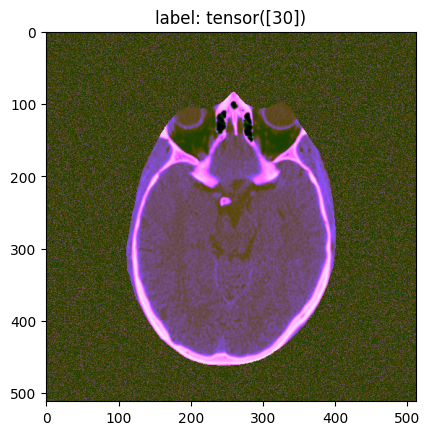

In [15]:
train_dataset = TrainDataset(train, transform=None)

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f'label: {label}')
    plt.show() 

# Transforms

In [16]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            #Resize(CFG.size, CFG.size),
            A.RandomResizedCrop(CFG.size, CFG.size, scale=(0.85, 1.0)),
            A.ShiftScaleRotate(p=0.5, rotate_limit=15),
            A.HorizontalFlip(p=0.5),
            # A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=5, val_shift_limit=5, p=0.1),
            # A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            # A.CLAHE(clip_limit=(1,4), p=0.1),
            A.Cutout(max_h_size=int(CFG.size * 0.05), max_w_size=int(CFG.size * 0.05), num_holes=5, p=0.1),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return Compose([
            A.Resize(CFG.size, CFG.size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

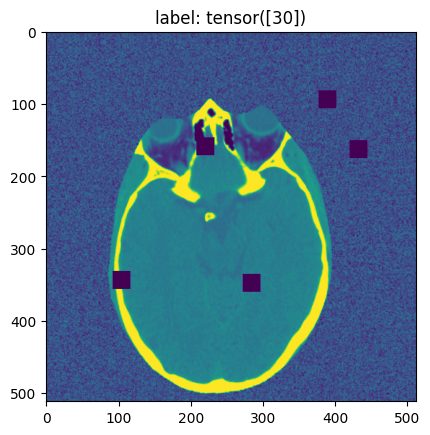

In [17]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

# Helper functions

In [21]:
def mixup_data(x, y, alpha=.1):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred.view(-1), y_a.view(-1).float()) + (1 - lam) * criterion(pred.view(-1), y_b.view(-1).float())

In [26]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.apex:
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        if CFG.apex:
            with autocast():
                y_preds = model(images)
                loss = criterion(y_preds.view(-1), labels.view(-1).float())
        else:
            y_preds = model(images)
            loss = criterion(y_preds.view(-1), labels.view(-1).float())
        if CFG.batch_scheduler:
          scheduler.step()
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            if CFG.apex:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   lr = optimizer.param_groups[0]["lr"]
                   ))
    return losses.avg

def train_fn_mixup(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.apex:
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images, labels_a, labels_b, lam = mixup_data(images, labels)
        images = images.to(device)
        labels_a = labels_a.to(device)
        labels_b = labels_b.to(device)
        batch_size = images.size(0)
        if CFG.apex:
            with autocast():
                y_preds = model(images)
                loss = mixup_criterion(criterion, y_preds, labels_a, labels_b, lam)
        else:
            y_preds = model(images)
            loss = mixup_criterion(criterion, y_preds, labels_a, labels_b, lam)
        if CFG.batch_scheduler:
          scheduler.step()
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            if CFG.apex:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   lr = optimizer.param_groups[0]["lr"]
                   ))
    return losses.avg

def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds.view(-1), labels.view(-1).float())
        losses.update(loss.item(), batch_size)
        # record accuracy
        # preds.append(y_preds.sigmoid().to('cpu').numpy())
        preds.append(y_preds.to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            # avg_preds.append(y_preds.sigmoid().to('cpu').numpy())
            avg_preds.append(y_preds.to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs


def inference_tta(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images) / 2
                y_preds += model(images.flip(-1)) / 2
            # avg_preds.append(y_preds.sigmoid().to('cpu').numpy())
            avg_preds.append(y_preds.to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

# Train loop

In [23]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    train_dataset = TrainDataset(train_folds, 
                             transform=get_transforms(data='train'))
    train_loader = DataLoader(train_dataset, 
                          batch_size=CFG.batch_size, 
                          shuffle=True, 
                          # sampler=sampler,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True)

    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
#         elif CFG.scheduler=='CosineLRScheduler':
#             scheduler = CosineLRScheduler(optimizer, t_initial=CFG.epochs, lr_min=CFG.min_lr, warmup_t=1, warmup_lr_init=1e-6, warmup_prefix=True)
        elif CFG.scheduler=='get_cosine_schedule_with_warmup':
            steps_per_epoch = len(train_dataset) // CFG.batch_size
            print("number of steps per epoch", steps_per_epoch)
            scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps= steps_per_epoch*CFG.warmup_epochs, num_training_steps= steps_per_epoch * CFG.epochs)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = timm.create_model(CFG.model_name, num_classes=len(CFG.target_cols), pretrained=True)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)


    # ====================================================
    # loop
    # ====================================================
    criterion = nn.L1Loss() #nn.BCEWithLogitsLoss() #nn.CrossEntropyLoss()

    best_score = np.inf
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        
        start_time = time.time()
        
        # train
        if CFG.mixup:
            avg_loss = train_fn_mixup(train_loader, model, criterion, optimizer, epoch, scheduler, device)
        else:
            avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_cols].values
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()
#         elif isinstance(scheduler, CosineLRScheduler):
#             scheduler.step(epoch+1)


        # scoring
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - MAE: {np.round(score, decimals=4)}')

        if score < best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    valid_folds[[f'pred_{c}' for c in CFG.target_cols]] = check_point['preds']
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds

In [24]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.test  3.submission  4.folds
    """

    def get_result(result_df):
        preds = result_df[[f'pred_{c}' for c in CFG.target_cols]].values
        labels = result_df[CFG.target_cols].values
        score = get_score(labels, preds)
        LOGGER.info(f'MAE: {score:<.4f}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
    
    if CFG.inference:
        # inference
        model = timm.create_model(CFG.model_name, num_classes=len(CFG.target_cols), pretrained=False)
        states = [torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth') for fold in CFG.trn_fold]
        test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
        test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, 
                                 num_workers=CFG.num_workers, pin_memory=True)
        
        # no post-process prediction
        predictions = inference(model, states, test_loader, device)
        test["Age"] = predictions
        result = test[["StudyID", "Age"]]
        sub = result.groupby('StudyID')['Age'].median().reset_index()
        # sub.to_csv(OUTPUT_DIR+f'submission_{EXP}.csv', index=False)
        
        # use 40 percentile of caudal end
        test["slice"] = test["file_path"].apply(lambda x: int(x.split("/")[-1].split("_")[-1].replace(".png", "")) )
        test['slice_percentile'] = test.groupby('StudyID')['slice'].rank(pct=True)
        test_04 = test[test["slice_percentile"] < 0.4].reset_index(drop=True)
        result = test_04[["StudyID", "Age"]]
        sub = result.groupby('StudyID')['Age'].mean().reset_index()
        sub.to_csv(OUTPUT_DIR+f'submission_{EXP}_caudal04.csv', index=False)

In [25]:
if __name__ == '__main__':
    torch.cuda.empty_cache()
    gc.collect()
    main()

========== fold: 0 training ==========


number of steps per epoch 8506

Epoch: [1][0/8506] Data 0.956 (0.956) Elapsed 0m 2s (remain 413m 48s) Loss: 33.1149(33.1149) Grad: inf  LR: 0.000000  

Epoch: [1][100/8506] Data 0.000 (0.010) Elapsed 0m 37s (remain 52m 33s) Loss: 12.0081(22.4192) Grad: 879430.9375  LR: 0.000012  

Epoch: [1][200/8506] Data 0.000 (0.005) Elapsed 1m 13s (remain 50m 18s) Loss: 10.1357(16.8157) Grad: 709550.6250  LR: 0.000024  

Epoch: [1][300/8506] Data 0.000 (0.003) Elapsed 1m 48s (remain 49m 14s) Loss: 10.8467(14.5289) Grad: 687119.8750  LR: 0.000035  

Epoch: [1][400/8506] Data 0.000 (0.002) Elapsed 2m 23s (remain 48m 26s) Loss: 7.0579(13.1749) Grad: 569124.7500  LR: 0.000047  

Epoch: [1][500/8506] Data 0.000 (0.002) Elapsed 2m 59s (remain 47m 43s) Loss: 9.3174(12.3108) Grad: 549675.5000  LR: 0.000059  

Epoch: [1][600/8506] Data 0.000 (0.002) Elapsed 3m 34s (remain 47m 4s) Loss: 7.9964(11.6880) Grad: 481404.3438  LR: 0.000071  

Epoch: [1][700/8506] Data 0.000 (0.001) Elapsed 4m 10s (remain 46m 25s) 

Epoch 1 - avg_train_loss: 6.6434  avg_val_loss: 7.4151  time: 3181s

Epoch 1 - MAE: 7.4151

Epoch 1 - Save Best Score: 7.4151 Model


EVAL: [976/977] Data 0.000 (0.001) Elapsed 2m 49s (remain 0m 0s) Loss: 6.2285(7.4151) 

Epoch: [2][0/8506] Data 1.324 (1.324) Elapsed 0m 1s (remain 238m 39s) Loss: 5.5605(5.5605) Grad: 480674.1250  LR: 0.001000  

Epoch: [2][100/8506] Data 0.000 (0.013) Elapsed 0m 37s (remain 51m 30s) Loss: 5.7529(5.7903) Grad: 545781.3125  LR: 0.001000  

Epoch: [2][200/8506] Data 0.000 (0.007) Elapsed 1m 12s (remain 49m 55s) Loss: 7.2855(6.2634) Grad: 245386.0469  LR: 0.001000  

Epoch: [2][300/8506] Data 0.000 (0.004) Elapsed 1m 47s (remain 49m 1s) Loss: 5.9867(6.4247) Grad: 270136.2500  LR: 0.001000  

Epoch: [2][400/8506] Data 0.000 (0.003) Elapsed 2m 23s (remain 48m 17s) Loss: 6.2777(6.4982) Grad: 246643.5000  LR: 0.001000  

Epoch: [2][500/8506] Data 0.000 (0.003) Elapsed 2m 58s (remain 47m 38s) Loss: 6.7604(6.5346) Grad: 277056.8750  LR: 0.000999  

Epoch: [2][600/8506] Data 0.000 (0.002) Elapsed 3m 34s (remain 47m 0s) Loss: 6.3135(6.5274) Grad: 239350.2656  LR: 0.000999  

Epoch: [2][700/8506]

Epoch 2 - avg_train_loss: 5.9679  avg_val_loss: 6.1194  time: 3166s

Epoch 2 - MAE: 6.1194

Epoch 2 - Save Best Score: 6.1194 Model


EVAL: [976/977] Data 0.000 (0.001) Elapsed 2m 49s (remain 0m 0s) Loss: 10.0544(6.1194) 

Epoch: [3][0/8506] Data 1.008 (1.008) Elapsed 0m 1s (remain 193m 30s) Loss: 4.9193(4.9193) Grad: 511984.7812  LR: 0.000854  

Epoch: [3][100/8506] Data 0.000 (0.011) Elapsed 0m 36s (remain 50m 25s) Loss: 5.9694(5.1959) Grad: 278493.6250  LR: 0.000850  

Epoch: [3][200/8506] Data 0.000 (0.005) Elapsed 1m 11s (remain 49m 6s) Loss: 5.5999(5.2035) Grad: 238709.0469  LR: 0.000847  

Epoch: [3][300/8506] Data 0.000 (0.004) Elapsed 1m 46s (remain 48m 20s) Loss: 6.5462(5.2098) Grad: 212344.9531  LR: 0.000844  

Epoch: [3][400/8506] Data 0.000 (0.003) Elapsed 2m 21s (remain 47m 36s) Loss: 5.7839(5.2210) Grad: 278705.2812  LR: 0.000840  

Epoch: [3][500/8506] Data 0.000 (0.002) Elapsed 2m 56s (remain 46m 56s) Loss: 5.6852(5.2305) Grad: 217903.8594  LR: 0.000837  

Epoch: [3][600/8506] Data 0.000 (0.002) Elapsed 3m 31s (remain 46m 18s) Loss: 7.5296(5.2384) Grad: 253521.4688  LR: 0.000833  

Epoch: [3][700/850

Epoch 3 - avg_train_loss: 5.0985  avg_val_loss: 6.0251  time: 3146s

Epoch 3 - MAE: 6.0251

Epoch 3 - Save Best Score: 6.0251 Model


EVAL: [976/977] Data 0.000 (0.006) Elapsed 2m 54s (remain 0m 0s) Loss: 9.6060(6.0251) 

Epoch: [4][0/8506] Data 1.010 (1.010) Elapsed 0m 1s (remain 196m 21s) Loss: 3.9626(3.9626) Grad: 637087.4375  LR: 0.000500  

Epoch: [4][100/8506] Data 0.000 (0.010) Elapsed 0m 36s (remain 50m 17s) Loss: 4.3034(4.6998) Grad: 308720.0312  LR: 0.000495  

Epoch: [4][200/8506] Data 0.000 (0.005) Elapsed 1m 11s (remain 48m 59s) Loss: 4.7542(4.6231) Grad: 292684.6562  LR: 0.000491  

Epoch: [4][300/8506] Data 0.000 (0.003) Elapsed 1m 46s (remain 48m 9s) Loss: 3.5033(4.6101) Grad: 156598.6562  LR: 0.000486  

Epoch: [4][400/8506] Data 0.000 (0.003) Elapsed 2m 20s (remain 47m 26s) Loss: 5.0492(4.6451) Grad: 125114.0312  LR: 0.000481  

Epoch: [4][500/8506] Data 0.000 (0.002) Elapsed 2m 55s (remain 46m 47s) Loss: 6.1432(4.7004) Grad: 145803.7656  LR: 0.000477  

Epoch: [4][600/8506] Data 0.000 (0.002) Elapsed 3m 30s (remain 46m 8s) Loss: 5.1442(4.7200) Grad: 132917.5312  LR: 0.000472  

Epoch: [4][700/8506]

Epoch 4 - avg_train_loss: 4.3322  avg_val_loss: 5.6483  time: 3142s

Epoch 4 - MAE: 5.6483

Epoch 4 - Save Best Score: 5.6483 Model


EVAL: [976/977] Data 0.000 (0.008) Elapsed 2m 56s (remain 0m 0s) Loss: 9.3391(5.6483) 

Epoch: [5][0/8506] Data 1.312 (1.312) Elapsed 0m 1s (remain 236m 54s) Loss: 3.8864(3.8864) Grad: 613520.2500  LR: 0.000146  

Epoch: [5][100/8506] Data 0.000 (0.013) Elapsed 0m 36s (remain 50m 41s) Loss: 3.8688(3.9861) Grad: 302290.8750  LR: 0.000143  

Epoch: [5][200/8506] Data 0.000 (0.007) Elapsed 1m 11s (remain 49m 11s) Loss: 3.8757(3.9352) Grad: 423841.8750  LR: 0.000140  

Epoch: [5][300/8506] Data 0.000 (0.004) Elapsed 1m 46s (remain 48m 16s) Loss: 3.5960(3.8965) Grad: 385677.1562  LR: 0.000137  

Epoch: [5][400/8506] Data 0.000 (0.003) Elapsed 2m 21s (remain 47m 32s) Loss: 4.8877(3.8972) Grad: 341172.9375  LR: 0.000134  

Epoch: [5][500/8506] Data 0.000 (0.003) Elapsed 2m 55s (remain 46m 51s) Loss: 3.7926(3.8714) Grad: 322043.0000  LR: 0.000130  

Epoch: [5][600/8506] Data 0.000 (0.002) Elapsed 3m 30s (remain 46m 13s) Loss: 4.6533(3.8877) Grad: 307989.2188  LR: 0.000127  

Epoch: [5][700/850

Epoch 5 - avg_train_loss: 3.7377  avg_val_loss: 5.5467  time: 3144s

Epoch 5 - MAE: 5.5467

Epoch 5 - Save Best Score: 5.5467 Model


EVAL: [976/977] Data 0.000 (0.012) Elapsed 3m 0s (remain 0m 0s) Loss: 9.0108(5.5467) 


========== fold: 0 result ==========

MAE: 5.5467

========== fold: 1 training ==========


number of steps per epoch 8531

Epoch: [1][0/8531] Data 1.404 (1.404) Elapsed 0m 1s (remain 249m 40s) Loss: 50.1456(50.1456) Grad: inf  LR: 0.000000  


Exception in thread Thread-16 (_pin_memory_loop):

Traceback (most recent call last):

  File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner

    self.run()

  File "/opt/conda/lib/python3.10/threading.py", line 953, in run

    self._target(*self._args, **self._kwargs)

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 51, in _pin_memory_loop

    do_one_step()

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 28, in do_one_step

    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)

  File "/opt/conda/lib/python3.10/multiprocessing/queues.py", line 122, in get

    return _ForkingPickler.loads(res)

  File "/opt/conda/lib/python3.10/site-packages/torch/multiprocessing/reductions.py", line 307, in rebuild_storage_fd

    fd = df.detach()

  File "/opt/conda/lib/python3.10/multiprocessing/resource_sharer.py", line 57, in detach

    with _resource_sharer.get_connection(self

KeyboardInterrupt: 